In [82]:
import os
from dotenv import load_dotenv

load_dotenv()

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np

# For geospatial analysis
import folium
from folium.plugins import HeatMap

### Importing data
Kaggle Data Source: https://www.kaggle.com/datasets/ananthu017/california-wildfire-incidents-20132020 *originally by https://www.fire.ca.gov/*

In [83]:
path = './data/california_wildfires_2013-2020.csv'

df = pd.read_csv(path, sep=',', encoding='latin-1')

### Getting to know the data
Explaining all variables.

In [84]:
df.columns

Index(['AcresBurned', 'Active', 'AdminUnit', 'AirTankers', 'ArchiveYear',
       'CalFireIncident', 'CanonicalUrl', 'ConditionStatement',
       'ControlStatement', 'Counties', 'CountyIds', 'CrewsInvolved', 'Dozers',
       'Engines', 'Extinguished', 'Fatalities', 'Featured', 'Final',
       'FuelType', 'Helicopters', 'Injuries', 'Latitude', 'Location',
       'Longitude', 'MajorIncident', 'Name', 'PercentContained',
       'PersonnelInvolved', 'Public', 'SearchDescription', 'SearchKeywords',
       'Started', 'Status', 'StructuresDamaged', 'StructuresDestroyed',
       'StructuresEvacuated', 'StructuresThreatened', 'UniqueId', 'Updated',
       'WaterTenders'],
      dtype='object')

Variables of the wildifire dataset:
- **Acres Burned**: Acres of land affected by wildfires
- **Active**: If the fire is active or contained?
- **AdminUnit**: Fire department which is directly assigned to fire
- **AirTankers**: Number of airplane resources assigned
- **ArchiveYear**: Year the data was archived
- **CalFireIncident**: Is the incident treated as a CalFire incident?
- **CanonicalUrl**: Url of record
- **ConditionStatement**: Short report of the wildfire's condition
- **ControlStatement**: Short report of measures and fire control
- **Counties**: Affected County
- **CountyIds**: Affected County ID
- **CrewsInvolved**: Number of firefighter teams assigned
- **Dozers**: Number of dozers assigned
- **Engines**: Number of engines assigned
- **Extinguished**: Date of successful extinguish
- **Fatalities**: Number of fatalities
- **Featured**
- **Final**
- **FuelType**: Type of what material is keeping the fire going (e.g. Grass)
- **Helicopters**: Number of helicopters assigned
- **Injuries**: Count of injured personnel
- **Latitude**: Latitude of wildfire incident
- **Location**: Description of the location
- **Longitude**: Longitude of wildfire incident
- **MajorIncident**: Is the incident considered a major incident?
- **Name**: Name of the wildfire
- **PercentContained**: Percentage of wildfire that is contained
- **PersonnelInvolved**: Number of firefighters involved
- **Public**
- **SearchDescription**: Short description for fire, helping search
- **SearchKeywords**: Keywords, helping search
- **Started**: Fire start date
- **Status**: Status of the fire
- **StructuresDamaged**: Number of structures damaged
- **StructuresDestroyed**: Number of structures completely destroyed
- **StructuresEvacuated**: Number of structures evacuated
- **StructuresThreatened**: Number of structures threatened
- **UniqueId**: Unique identifier for a fire
- **Updated**: Last update date
- **WaterTenders**: Number of water tenders assigned

#### Lets see if there are any variables that aren't expressive & meaningful

In [85]:
# Print variables that are completely null values
null_cols = df.columns[df.isnull().all()]
print('Following columns are completely made up of null values: ',null_cols)

# Drop null_cols
df.drop(null_cols, axis=1, inplace=True)

Following columns are completely made up of null values:  Index(['StructuresEvacuated'], dtype='object')


### Geospatial Analysis
Which counties are most affected by wildfires?

Lets first look at coordinates

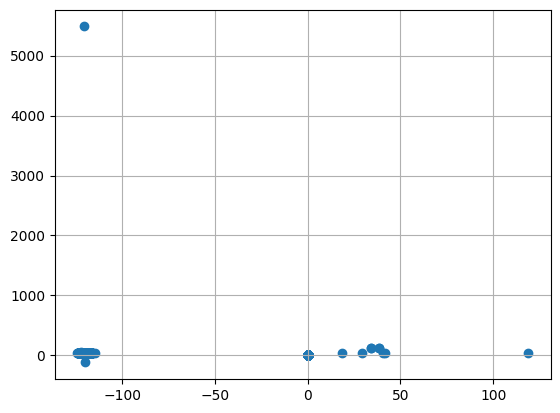

In [86]:
# Check coordinates
plt.scatter(df.Longitude, df.Latitude)
plt.grid()
plt.show()

There are a couple of points which lie outside California's latitude and logitude. So let's remove them.

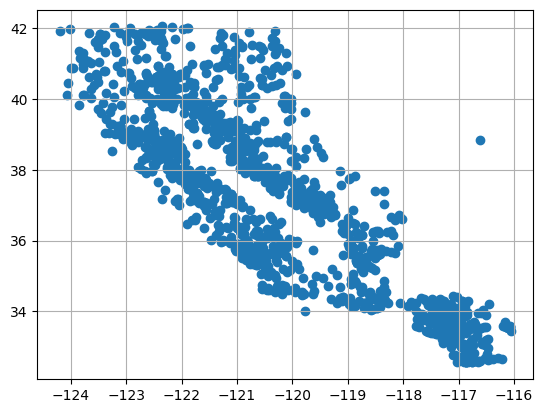

In [87]:
# Remove rows of coordinates which lie outside of California
df_select = df[df.Longitude<-115]
df_select = df_select[(df_select.Latitude<44) & (df_select.Latitude > 30)]
plt.scatter(df_select.Longitude, df_select.Latitude)
plt.grid()
plt.show()

Now we can already see the State of California's shape.
There still seems to be one recorded fire more to the right of California, it looks like it is in Nevada --- Let's look at it.

In [88]:
# Look at the outlier
outlier = df_select[df_select.CanonicalUrl=='/incidents/2013/8/6/tram-fire/']

df.iloc[113]

AcresBurned                                                          60.0
Active                                                              False
AdminUnit                                  San Bernardino National Forest
AirTankers                                                            NaN
ArchiveYear                                                          2013
CalFireIncident                                                     False
CanonicalUrl                               /incidents/2013/8/6/tram-fire/
ConditionStatement                                                    NaN
ControlStatement                                                      NaN
Counties                                                        Riverside
CountyIds                                                              33
CrewsInvolved                                                         NaN
Dozers                                                                NaN
Engines                               

When looking at the latitude and longitude of that row: (Lat: 38.838, Long: -116.61) when using Google Maps, we can see that this location sits in the [middle of Nevada](https://goo.gl/maps/8pcHrJsA5ede2KW28). We can observe that the longitude is correct as it is on the same vertical axis as the Palm Springs Tramway Rd. Through the description of the record we can set the correct latitude from the [location](https://goo.gl/maps/EQvrHKq8cALUURGt9) as 33.845993, -116.611936.

In [89]:
# Set the outliers latitude to 33.845993
df_select.at[113, 'Latitude'] = 33.845993

In [105]:
px.set_mapbox_access_token(token=os.getenv('MAPBOX_ACCESS_TOKEN'))


fig = px.density_mapbox(df_select, lat='Latitude', lon='Longitude', z='AcresBurned', radius=35,
                        center=dict(lat=38, lon=-120), zoom=4.75,
                        mapbox_style=os.getenv('MAPBOX_STYLE'), opacity=0.75)

fig.update_layout(
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0),
    width=800
)

fig.update_coloraxes(colorbar_title='Acres Burned')

# Coordinates for Los Angeles and San Francisco
locations = {
    "Los Angeles": {"lat": 34.0522, "lon": -118.2437},
    "San Francisco": {"lat": 37.7749, "lon": -122.4194}
}

# Add text for Los Angeles and San Francisco
for city, coord in locations.items():
    fig.add_trace(go.Scattermapbox(
        lat=[coord["lat"]],
        lon=[coord["lon"]],
        mode='markers+text',
        marker=go.scattermapbox.Marker(size=0),
        text=[city],
        textposition='middle center',
        textfont=dict(color='white', size=15),
        showlegend=False
    ))

fig.show()

### Taking a closer look at how months relate to fires

In [91]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from dateutil.parser import parse

# Check if 'Started' is already datetime format
if not is_datetime(df['Started']):
    df['Started'] = df['Started'].apply(parse)

# Extract month and create a new column 'Month'
df['Month'] = df['Started'].dt.month


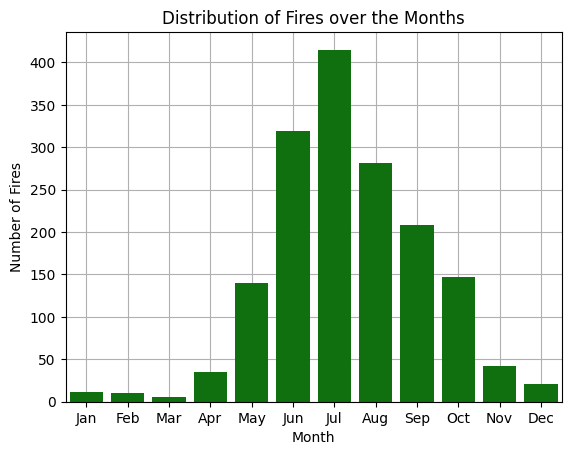

In [92]:
import calendar
import matplotlib.colors as mcolors

# Plot the distribution of fires over the months
month_counts = df['Month'].value_counts().sort_index()

ax = sns.barplot(x=month_counts.index, y=month_counts, zorder=2, color='g')
ax.set_ylabel('Number of Fires')
ax.set_title('Distribution of Fires over the Months')

# Set x-axis labels to month names
month_names = [calendar.month_abbr[i] for i in range(1, 13)]
plt.xticks(np.arange(12), month_names)

# Enable grid and set zorder to 1 (below bars)
plt.grid(True, zorder=1)

plt.show()